This notebook tries to build a model with locationa as input.

In [80]:
# imports
import pandas as pd
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras import Model
from keras import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from keras import Input
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

## Load data from GCS bucket

In [2]:
BUCKET_NAME = 'salary-data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
df_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'data_location_buckets.csv'))

In [96]:
# Select only the location data
#df_sub = df_train[['LocationNormalized','TTWA_County','SalaryNormalized']]
df_sub = df_train[['Category','SalaryNormalized']]

In [10]:
df_sub['Final_location'] = df_sub.TTWA_County
df_sub.Final_location[df_sub.TTWA_County.isna()] = df_sub.LocationNormalized[df_sub.TTWA_County.isna()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

In [99]:
# Check unique locations
# print(df_sub.TTWA_County.describe())
# print(df_sub.Final_location.describe())


count      244768
unique         29
top       IT Jobs
freq        38483
Name: Category, dtype: object

# Train model with TTWA_County location

## Prep data

In [100]:
# df_noNaN = df_sub.dropna()
# X = df_noNaN.TTWA_County.values
# y = df_noNaN.SalaryNormalized.values
df_noNaN = df_sub.dropna()
X = df_noNaN.Category.values
y = df_noNaN.SalaryNormalized.values

Hot-encode the location

In [102]:
enc = OneHotEncoder()
X = enc.fit_transform(X.reshape(-1, 1))

In [103]:
X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split( X_train_full, y_train_full, test_size=0.2, random_state=42)

## Build model

In [126]:
input_ = Input(shape=(X_train.shape[1]),)
x = Dense(10, activation='relu')(input_)
x = Dense(1, activation='linear')(x)
x = Model(inputs=input_,outputs = x)

x.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 29)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                300       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________


In [127]:
x.compile(loss = 'mean_squared_error', optimizer = 'Adam')

In [128]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
epochs = 10
batch_size = 8

history = x.fit(X_train, y_train, epochs =epochs, batch_size = batch_size, verbose = 2, validation_data = (X_val, y_val),
               callbacks = es)

Epoch 1/10
19582/19582 - 43s - loss: 1331966464.0000 - val_loss: 1097228160.0000
Epoch 2/10
19582/19582 - 39s - loss: 780875264.0000 - val_loss: 489708480.0000
Epoch 3/10
19582/19582 - 42s - loss: 345337632.0000 - val_loss: 288177216.0000
Epoch 4/10
19582/19582 - 43s - loss: 280050784.0000 - val_loss: 279170336.0000
Epoch 5/10
19582/19582 - 41s - loss: 274159136.0000 - val_loss: 275190208.0000
Epoch 6/10
19582/19582 - 37s - loss: 271073184.0000 - val_loss: 273005696.0000
Epoch 7/10
19582/19582 - 40s - loss: 269309248.0000 - val_loss: 271745728.0000
Epoch 8/10
19582/19582 - 40s - loss: 268235856.0000 - val_loss: 270979136.0000
Epoch 9/10
19582/19582 - 43s - loss: 267526208.0000 - val_loss: 270459904.0000
Epoch 10/10
19582/19582 - 40s - loss: 267032720.0000 - val_loss: 270110816.0000


## Evaluate and predict

In [129]:
loss = x.evaluate(X_test, y_test,verbose =1)

1530/1530 [==============================] - 3s 2ms/step - loss: 266849056.0000


In [130]:
y_mean = np.mean(y_train)
rmse_mean = round(np.sqrt(np.mean((y_test-y_mean)**2)))
print("Mean RMSE = {}".format(rmse_mean))
print("Model RMSE = {}".format(round(np.sqrt(loss))))

Mean RMSE = 17638
Model RMSE = 16336


In [131]:
y_pred = x.predict(X_test,verbose = 1)

1530/1530 [==============================] - 2s 1ms/step


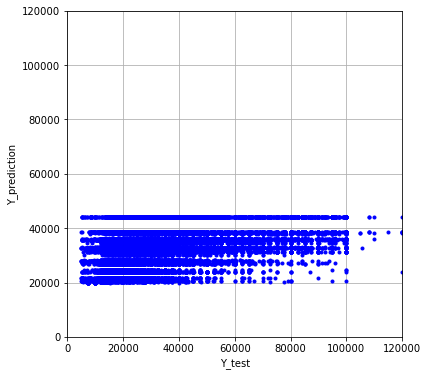

In [132]:
limits= [0,120000]
fig = plt.figure(figsize = (6,6))  
ax = fig.add_subplot(1, 1, 1)  
ax.plot(y_test, y_pred, 'b.')
ax.set_ylabel('Y_prediction')
ax.set_xlabel('Y_test')
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.grid()
plt.show()